<a href="https://colab.research.google.com/github/asheta66/CNN/blob/main/Chest%20X_Ray/TL_for_Diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# ===============================
# Core Libraries
# ===============================
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===============================
# Scikit-learn Metrics
# ===============================
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc
)

# ===============================
# TensorFlow / Keras
# ===============================
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import (
    VGG16,
    ResNet50,
    InceptionV3,
    MobileNetV2
)

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input,
    Dense,
    Dropout,
    GlobalAveragePooling2D,
    Conv2D,
    MaxPooling2D,
    BatchNormalization,
    Flatten
)

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ReduceLROnPlateau
)


In [14]:
# ============================================================
# 1. Mount Google Drive
# ============================================================
from google.colab import drive
import os
import shutil
import random
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

drive.mount('/content/drive')

# ============================================================
# 2. Reproducibility
# ============================================================
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ============================================================
# 3. Data & Parameters
# ============================================================
DATA_DIR = '/content/drive/MyDrive/Chest X_Ray'  # root dataset folder
OUTPUT_DIR = '/content/Chest_XRay_split'         # output split folder

IMG_SIZE = (224, 224)
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 1e-4
N_CLASSES = 2
MAX_IMAGES_PER_CLASS = 500  # maximum images per class

# Split ratios
TRAIN_RATIO = 0.7
TEST_RATIO = 0.3

# ============================================================
# 4. Create directories for train/test
# ============================================================
train_dir = os.path.join(OUTPUT_DIR, 'train')
test_dir  = os.path.join(OUTPUT_DIR, 'test')

for folder in [train_dir, test_dir]:
    for cls in ['NORMAL', 'PNEUMONIA']:
        os.makedirs(os.path.join(folder, cls), exist_ok=True)

# ============================================================
# 5. Split dataset (Train/Test Only)
# ============================================================
for cls in ['NORMAL', 'PNEUMONIA']:
    cls_dir = os.path.join(DATA_DIR, cls)
    images = [
        img for img in os.listdir(cls_dir)
        if img.lower().endswith(('.png', '.jpg', '.jpeg'))
    ][:MAX_IMAGES_PER_CLASS]

    # Train/Test split
    train_imgs, test_imgs = train_test_split(
        images,
        test_size=TEST_RATIO,
        random_state=SEED,
        shuffle=True
    )

    # Copy images to train folder
    for img in train_imgs:
        shutil.copy(
            os.path.join(cls_dir, img),
            os.path.join(train_dir, cls, img)
        )

    # Copy images to test folder
    for img in test_imgs:
        shutil.copy(
            os.path.join(cls_dir, img),
            os.path.join(test_dir, cls, img)
        )

print("Dataset split completed successfully! Only train and test sets are created.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset split completed successfully! Only train and test sets are created.


In [15]:
import pandas as pd
import os

# ----------------------------
# Fixed Train/Test Split
# ----------------------------
def create_fixed_split(data_dir, train_ratio=TRAIN_RATIO, max_images_per_class=MAX_IMAGES_PER_CLASS, seed=SEED):
    images, labels = [], []

    # Collect images and labels
    for label in sorted(os.listdir(data_dir)):
        class_dir = os.path.join(data_dir, label)
        class_images = [img for img in os.listdir(class_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))][:max_images_per_class]

        for img in class_images:
            images.append(os.path.join(class_dir, img))
            labels.append(label)

    # Create DataFrame and shuffle
    df = pd.DataFrame({"filename": images, "class": labels})
    df = df.sample(frac=1, random_state=seed).reset_index(drop=True)

    # Compute split index
    n = len(df)
    train_end = int(n * train_ratio)

    # Return train and test DataFrames
    return df.iloc[:train_end], df.iloc[train_end:]

# ----------------------------
# Generate train/test DataFrames
# ----------------------------
train_df, test_df = create_fixed_split(DATA_DIR)

print(f"Train samples: {len(train_df)}")
print(f"Test samples:  {len(test_df)}")


Train samples: 700
Test samples:  300


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ----------------------------
# 1. Data Generators
# ----------------------------
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    horizontal_flip=True
)

test_gen = ImageDataGenerator(rescale=1./255)

# ----------------------------
# 2. Training Generator
# ----------------------------
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col="filename",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=SEED
)

# ----------------------------
# 3. Testing Generator
# ----------------------------
test_data = test_gen.flow_from_dataframe(
    test_df,
    x_col="filename",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 700 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.


In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_model(base_model, n_classes=N_CLASSES, lr=LEARNING_RATE):
    """
    Build a transfer learning model with a frozen base.

    Args:
        base_model: Pre-trained Keras model (e.g., MobileNetV2, VGG16)
        n_classes: Number of output classes
        lr: Learning rate

    Returns:
        Compiled Keras model
    """
    # Freeze base model layers
    base_model.trainable = False

    # Add custom classifier on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.5)(x)
    output = Dense(n_classes, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [18]:
def train_model(model, train_data, epochs=EPOCHS):
    """
    Train the given model on the training data.

    Args:
        model: Compiled Keras model
        train_data: Training data generator
        epochs: Number of training epochs

    Returns:
        history: Keras History object containing training metrics
    """
    history = model.fit(
        train_data,
        epochs=epochs,
        verbose=1
    )
    return history


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def evaluate_model(model, train_data, test_data, class_names=None):
    """
    Evaluate the model on train and test data.

    - Shows confusion matrices as subplots
    - Shows a single ROC curve with train and test
    - Returns a dataframe with Accuracy, Precision, Recall, F1 for train and test

    Args:
        model: Trained Keras model
        train_data: Training data generator
        test_data: Testing data generator
        class_names: List of class names
    Returns:
        results_df: Pandas DataFrame with metrics
    """
    results = []

    # ----------------------------
    # 1. Predictions for train and test
    # ----------------------------
    y_true_train = train_data.classes
    y_prob_train = model.predict(train_data, verbose=0)
    y_pred_train = np.argmax(y_prob_train, axis=1)

    y_true_test = test_data.classes
    y_prob_test = model.predict(test_data, verbose=0)
    y_pred_test = np.argmax(y_prob_test, axis=1)

    # ----------------------------
    # 2. Confusion Matrices
    # ----------------------------
    fig, axes = plt.subplots(1, 2, figsize=(7,7))
    cm_train = confusion_matrix(y_true_train, y_pred_train)
    cm_test  = confusion_matrix(y_true_test, y_pred_test)

    sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", ax=axes[0])
    axes[0].set_title("Train Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("True")
    if class_names:
        axes[0].set_xticklabels(class_names)
        axes[0].set_yticklabels(class_names)

    sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", ax=axes[1])
    axes[1].set_title("Test Confusion Matrix")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("True")
    if class_names:
        axes[1].set_xticklabels(class_names)
        axes[1].set_yticklabels(class_names)

    plt.tight_layout()
    plt.show()

    # ----------------------------
    # 3. ROC Curves (single plot)
    # ----------------------------
    plt.figure(figsize=(6,6))

    # Train ROC
    y_true_train_bin = tf.keras.utils.to_categorical(y_true_train, num_classes=N_CLASSES)
    for i in range(N_CLASSES):
        fpr, tpr, _ = roc_curve(y_true_train_bin[:, i], y_prob_train[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, linestyle='--', label=f"Train Class {i} AUC={roc_auc:.3f}")

    # Test ROC
    y_true_test_bin = tf.keras.utils.to_categorical(y_true_test, num_classes=N_CLASSES)
    for i in range(N_CLASSES):
        fpr, tpr, _ = roc_curve(y_true_test_bin[:, i], y_prob_test[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Test Class {i} AUC={roc_auc:.3f}")

    plt.plot([0,1],[0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Train & Test")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ----------------------------
    # 4. Metrics Table
    # ----------------------------
    metrics = []
    for label, y_true, y_pred in [("Train", y_true_train, y_pred_train), ("Test", y_true_test, y_pred_test)]:
        acc  = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average="macro")
        rec  = recall_score(y_true, y_pred, average="macro")
        f1   = f1_score(y_true, y_pred, average="macro")
        metrics.append([label, acc, prec, rec, f1])

    results_df = pd.DataFrame(metrics, columns=["Dataset","Accuracy","Precision","Recall","F1"])
    return results_df



===== Training VGG16 =====


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 395s 35s/step - accuracy: 0.5160 - loss: 0.8103
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 394s 36s/step - accuracy: 0.5153 - loss: 0.7657
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 384s 35s/step - accuracy: 0.5736 - loss: 0.7581
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 388s 35s/step - accuracy: 0.5883 - loss: 0.6806
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 388s 35s/step - accuracy: 0.5699 - loss: 0.7005
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 385s 35s/step - accuracy: 0.5937 - loss: 0.6724
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 378s 34s/step - accuracy: 0.6565 - loss: 0.6048
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 379s 34s/step - accuracy: 0.6854 - loss: 0.6274
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 381s 34s/step - accuracy: 0.6813 - loss: 0.5886
Epoch 10/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 384s 34s/step - accuracy: 0.7245 - loss: 0.5508


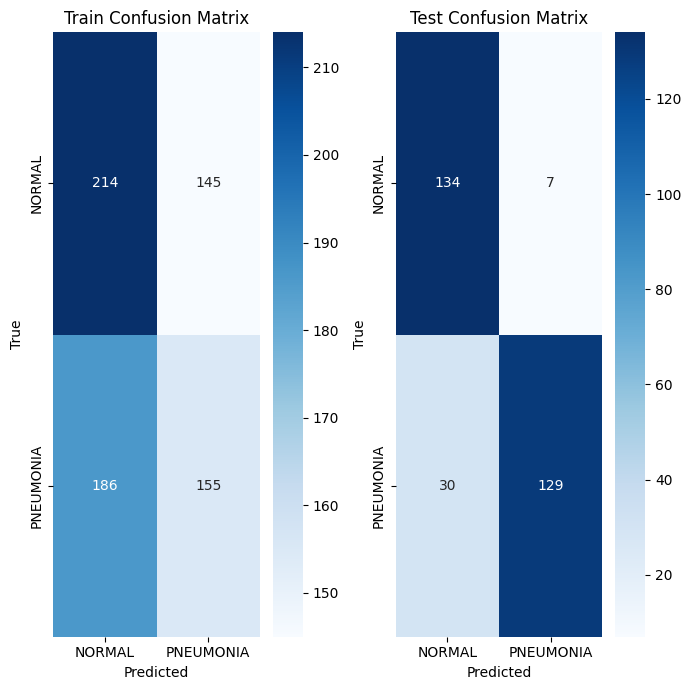

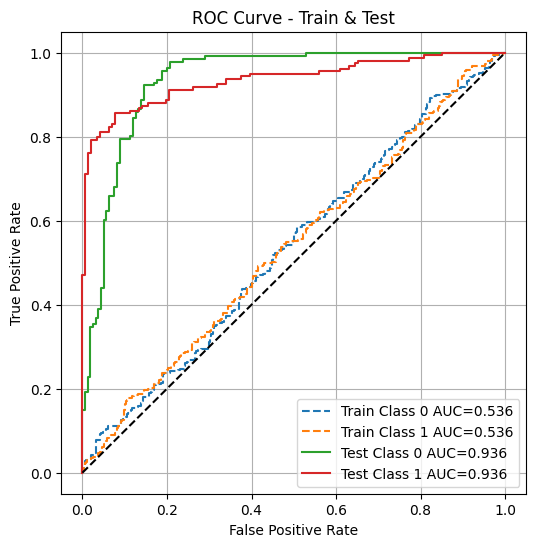


===== Training ResNet50 =====
Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 138s 11s/step - accuracy: 0.4867 - loss: 0.8040
Epoch 2/10
 6/11 ━━━━━━━━━━━━━━━━━━━━ 58s 12s/step - accuracy: 0.5229 - loss: 0.7550 

In [ ]:
models = {
    "VGG16": VGG16(weights="imagenet", include_top=False, input_shape=(*IMG_SIZE, 3)),
    "ResNet50": ResNet50(weights="imagenet", include_top=False, input_shape=(*IMG_SIZE, 3)),
    "InceptionV3": InceptionV3(weights="imagenet", include_top=False, input_shape=(*IMG_SIZE, 3)),
    "MobileNetV2": MobileNetV2(weights="imagenet", include_top=False, input_shape=(*IMG_SIZE, 3))
}

all_results = []

for name, base in models.items():
    print(f"\n===== Training {name} =====")

    # Build model
    model = build_model(base)

    # Train model
    history = train_model(model, train_data)

    # Evaluate model (train + test metrics, CM, ROC)
    results_df = evaluate_model(model, train_data, test_data, class_names=list(train_data.class_indices.keys()))

    # Add model name for comparison
    results_df["Model"] = name
    all_results.append(results_df)

# Combine all results into a single dataframe
final_results = pd.concat(all_results, ignore_index=True)
print("\n===== Summary of All Models =====")
final_results


In [ ]:
# =========================
# Statistical Comparison
# =========================
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import pandas as pd
import numpy as np

def compute_metrics(model, data, n_classes=N_CLASSES):
    """
    Compute Accuracy, Precision, Recall, F1, and AUC for given data
    """
    y_true = data.classes
    y_prob = model.predict(data, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)

    # For multi-class AUC, use one-vs-rest
    y_true_bin = tf.keras.utils.to_categorical(y_true, num_classes=n_classes)
    auc_list = []
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        auc_list.append(auc(fpr, tpr))

    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average="macro"),
        "Recall": recall_score(y_true, y_pred, average="macro"),
        "F1-score": f1_score(y_true, y_pred, average="macro"),
        "AUC": np.mean(auc_list)  # average AUC across classes
    }

# Dictionary to store results
results = {}

for name, base in models.items():
    print(f"Training and evaluating {name} for statistical comparison...")

    # Build and train model
    model = build_model(base)
    train_model(model, train_data)

    # Compute metrics on test data
    results[name] = compute_metrics(model, test_data)

# Create DataFrame
results_df = pd.DataFrame(results).T.round(4)
print("\n===== Statistical Comparison =====")
results_df


In [ ]:
styled_table = (
    results_df.style
    .highlight_max(axis=0, color="lightgreen")  # highlight best in each column
    .set_caption("Statistical Comparison of Transfer Learning Models")
    .set_table_styles([{"selector": "th", "props": [("text-align", "center")]}])
    .format("{:.4f}")  # format all numeric values to 4 decimals
)
styled_table
